### Import libraries

In [1]:
import os
import copy
import random

from pathlib import Path

import numpy as np
import pandas as pd

import networkx as nx

from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split

import torch
import torch.nn.functional as F
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout, Sigmoid

from torch_geometric.data import InMemoryDataset, Data
from torch_geometric.loader import DataLoader
from torch_geometric.io import fs

from torch_geometric.nn import GCNConv, GINConv, GATv2Conv, GraphConv
from torch_geometric.nn import global_mean_pool, global_add_pool, global_max_pool

from scipy.sparse import coo_matrix

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# reload modules
%load_ext autoreload
%autoreload 2

In [272]:
import sys

DIR_PATH = Path.cwd().parent
sys.path.append(str(DIR_PATH))

from utils import set_seed, set_device

from Dataset.data_loader import get_data
from Dataset.preprocessing import scale_adj, pad_ohe_features, scale_feature, get_train_val_test_masks

from Visualization.eda import histogram_classes, feature_bar_plots, violin_plots, corr_mtrx
from Visualization.graph import vis_graph, plot_graphs

### Fix Seeds

In [36]:
seed=42
set_seed(seed)
device = set_device()

data_type = 'balanced' # 'unbalanced' 
DATA_PATH = DIR_PATH / 'Data'
fig_path = DIR_PATH / f'Figures/{data_type}'
os.makedirs(fig_path, exist_ok=True)

Device: cuda


### Read the data

In [283]:
# load the adjacency matrices and the data
A, data = get_data(DATA_PATH, data_type)  

# Print information about the dataset
S, N = A.shape[0], A.shape[1]

display(data.head(5))

# store features in x (S, N, M) and labels in y (S, 1) 
x, y = np.expand_dims(data.iloc[:, 3:].values, axis=-1), np.expand_dims(data.iloc[:,2].values, axis=-1)
M = x.shape[-1]

print(f'Number of graphs: {S}')
print(f'Number of nodes: {N}')
print(f'Number of features per node: {M}')

# Check if every graph is connected
print(f'All connected: {all(nx.is_connected(nx.from_numpy_array(G)) for G in A)}')

,pat_id,conf,class,Prot1,Prot2,Prot3,Prot4,Prot5,Prot6,Prot7,...,Prot11,Prot12,Prot13,Prot14,Prot15,Prot16,Prot17,Prot18,Prot19,Prot20
0,1,0.165192,0,-0.288741,1.320418,1.246890,-0.587912,0.425350,1.433823,1.573993,...,1.338356,0.151599,1.333244,-0.893175,-0.736581,2.830105,-0.793974,-1.773393,2.129005,-0.543475
1,2,-0.513246,1,-0.973010,-0.083804,0.434048,1.785993,-1.266904,2.235005,0.844811,...,1.813073,0.427323,0.572022,0.844917,-1.381314,2.000934,0.857619,-4.184703,0.913778,-1.655555
2,3,-0.374802,1,-1.825425,1.211511,2.546314,0.161956,0.211815,4.396854,3.311472,...,-0.204465,-0.150981,1.128062,-0.049212,0.592243,-0.475274,-0.234234,-3.083168,3.457820,-1.471739
3,4,0.367808,1,0.449866,-0.493820,0.975631,1.253092,-1.101147,0.124996,1.165723,...,1.835069,-0.124808,1.011982,-0.066768,0.606598,4.985515,-0.124784,-1.378635,-0.934949,-1.366920
4,5,0.364785,1,-2.554269,-1.272309,0.446490,-1.364757,-0.525800,2.681961,0.755660,...,0.654083,-1.208418,1.341746,0.965073,0.798658,0.568156,2.077395,-2.634093,0.937716,0.327697


Number of graphs: 500
Number of nodes: 20
Number of features per node: 1
All connected: True


### EDA

In [5]:
def get_avg_degree_centrality(A: np.array) -> np.float64:
  """
    Calculate the average degree centrality of an adjacency matrix.
  """
  return np.mean(list(dict(nx.degree_centrality(nx.from_numpy_array(A))).values()))

def get_avg_closeness_centrality(A: np.array) -> np.float64:
  """
    Calculate the average closeness centrality of an adjacency matrix.
  """
  return np.mean(list(dict(nx.closeness_centrality(nx.from_numpy_array(A))).values()))

def get_avg_betweenness_centrality(A: np.array) -> np.float64:
  """
    Calculate the average betweenness centrality of an adjacency matrix.
  """
  return np.mean(list(dict(nx.betweenness_centrality(nx.from_numpy_array(A))).values()))

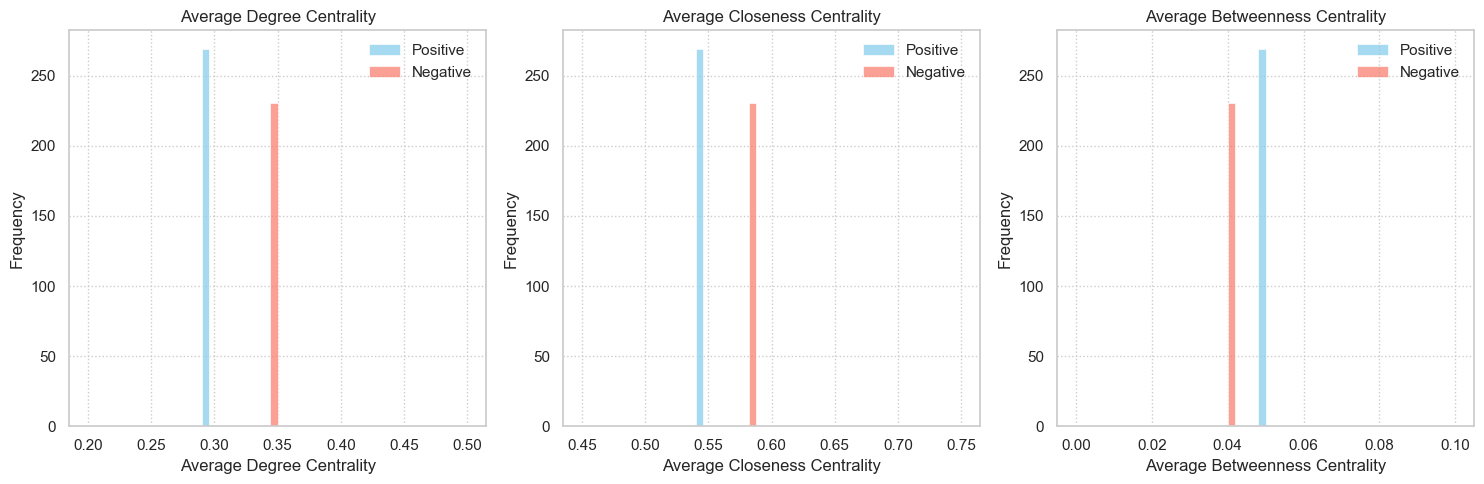

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

In [47]:
# Store the adjacency matrices for each of the classes
A_pos = A[np.where(y==0)[0]]
A_neg = A[np.where(y==1)[0]]

# Compute average degree centrality for each sample per class
deg_pos_mean = [get_avg_degree_centrality(a) for a in A_pos]
deg_neg_mean = [get_avg_degree_centrality(a) for a in A_neg]

# Compute average closeness centrality for each sample per class
cls_pos_mean = [get_avg_closeness_centrality(a) for a in A_pos]
cls_neg_mean = [get_avg_closeness_centrality(a) for a in A_neg]

# Compute average betweenness centrality for each sample per class
btw_pos_mean = [get_avg_betweenness_centrality(a) for a in A_pos]
btw_neg_mean = [get_avg_betweenness_centrality(a) for a in A_neg]


# Combine data and metrics into lists
pos_data = [deg_pos_mean, cls_pos_mean, btw_pos_mean]
neg_data = [deg_neg_mean, cls_neg_mean, btw_neg_mean]
metrics = ['Degree Centrality', 'Closeness Centrality', 'Betweenness Centrality']
binranges = [(0.2, 0.5), (0.45, 0.75), (0, 0.1)]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
# Iterate over the data and metrics to create each subplot
for i, (pos, neg, metric, binrange) in enumerate(zip(pos_data, neg_data, metrics, binranges)):
        histogram_classes(pos, neg, metric, ax=axes[i], bins=50, binrange=binrange)  

fig.tight_layout()  # Adjust subplots to fit into figure area.
fig.savefig(fig_path / 'histogram.png')  # Save the figure before showing it.

Apparently, we can already differentiate between positive and negative based on just the graph structure. **A perfect classifier just using a threshold**, do we even need any GNNs after this? We will further analyze the node features to see if there is a similar way to distinguish between the classes and apply some SOTA GNN models.

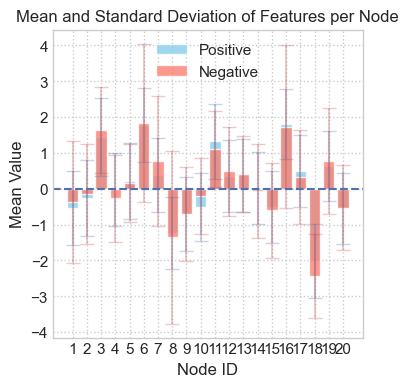

In [204]:
# plot the bars of mean and with std values
x_pos = x[np.where(y==0)[0]].squeeze()
x_neg = x[np.where(y==1)[0]].squeeze()

save_path = fig_path / 'bar_plot.png'
feature_bar_plots(x_pos, x_neg, save_path)

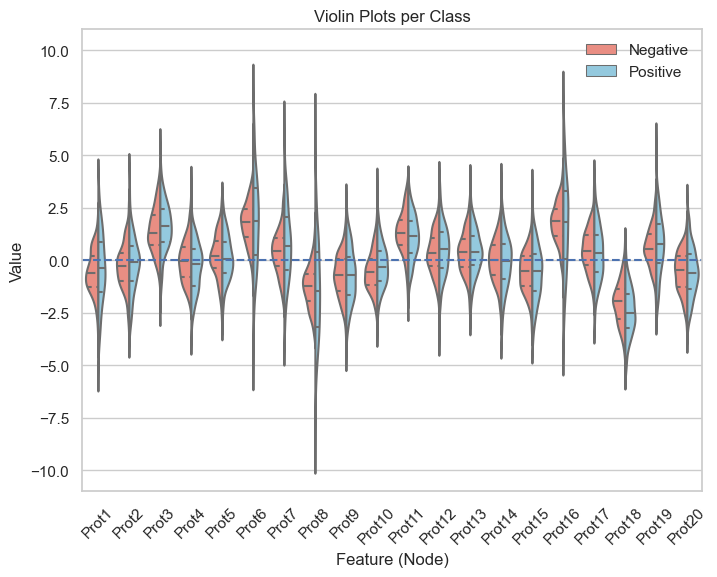

In [42]:
# Plot the violin plot of the features
df_melted = pd.melt(data, id_vars=['class'], 
                    value_vars=[f'Prot{i}' for i in range(1, N+1)], 
                    var_name='Protein', value_name='Expression')
                                                                                                                                                                                                                                                                                                                                                                                                   
save_path = fig_path / 'violins.png'
violin_plots(df_melted, save_path)

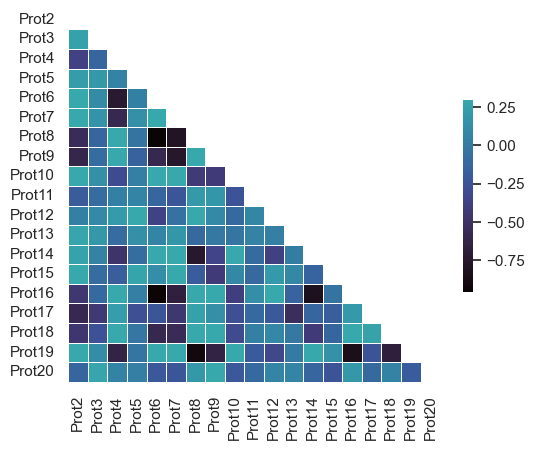

In [45]:
# Plot the correlation between the features
corr = data.iloc[:, 2:].corr()

save_path = fig_path / 'correlation.png'
corr_mtrx = corr_mtrx(corr, save_path)

The features seem to have a Gaussian distribution. They do not provide a strong correlation with the **class** target, although some features, such as **Prot18**, **Prot11** seem to be more correlated, which is confirmed by the violin plats, which show a small difference in the mean values per class.

Graph 1, Negative class


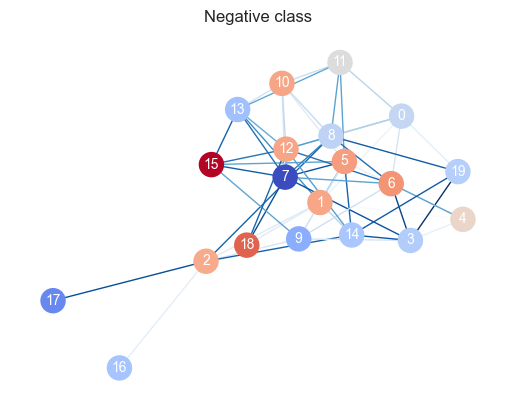

In [297]:
# Visualize one graph and color the nodes according to the feature values
idx = 0
label = 'Positive' if y[idx]==1 else 'Negative'

print(f'Graph {idx+1}, {label} class')

save_path = fig_path / f'graph_{label}.png'
vis_graph(A[idx], x[idx, :, 0], label, save_path)


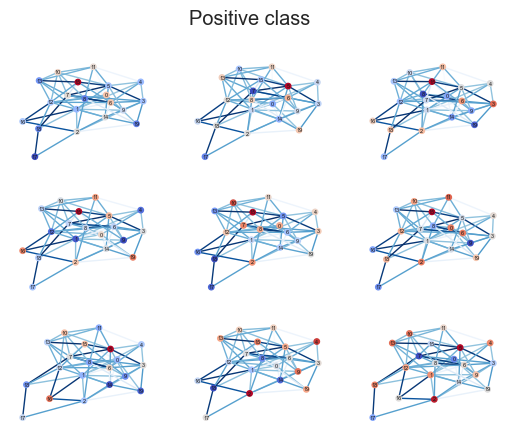

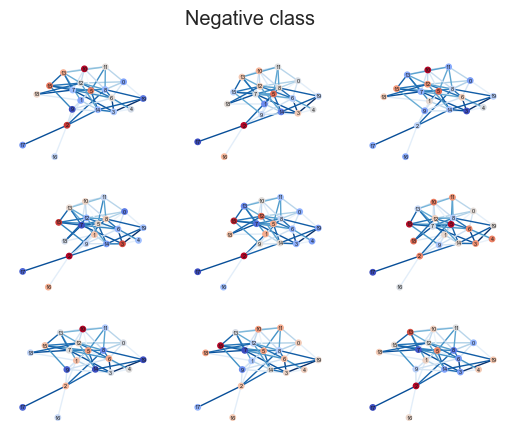

In [294]:
# Plot a few graphs of both classes together
plot_graphs(A, x, y, 9, 'Positive')
plot_graphs(A, x, y, 9, 'Negative')

## Data Preprocessing

Number of samples: Training 350 | Validation 75 | Testing 75


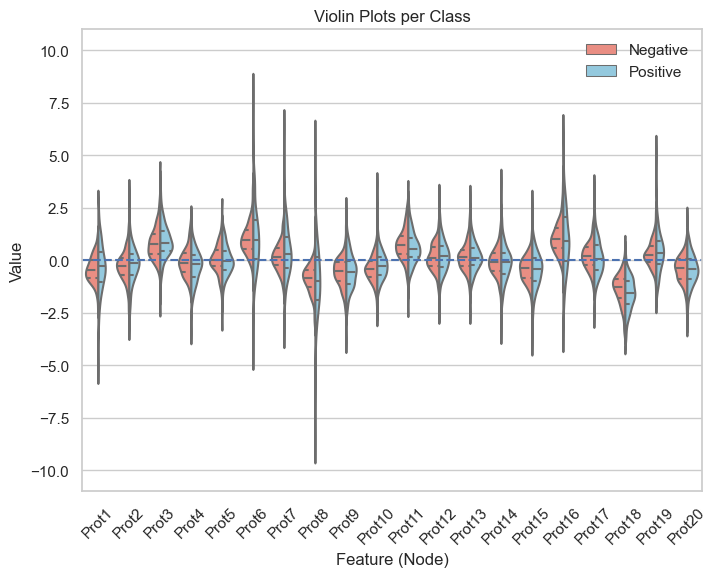

In [280]:
SCALE_ADJ_WEIGHTS = True
ADD_OHE_FEATURES = True
NORMALIZE_FEATURES = True 

if SCALE_ADJ_WEIGHTS:
    # Scale the weights of the adjacency matrices
    A = scale_adj(A)    

if ADD_OHE_FEATURES:
    # Add the identifiers of each node as a OHE feature
    x = pad_ohe_features(x, N)
    # Number of features is increased by the number of nodes
    M += N

# Split the data into train, validation, and test sets
train_mask, val_mask, test_mask = get_train_val_test_masks(S, y)

if NORMALIZE_FEATURES: # TODO: Check this 
    # Standardize the features from a list features_id 
    features_id = [0] # list of features (columns) you want to scale
    for feature_id in features_id:
        x = scale_feature(x, feature_id, train_mask, val_mask, test_mask)
        
         # check the distribution
        data_scaled = np.hstack((x[:, :, feature_id], y))
        
        df = pd.DataFrame(data=data_scaled, columns=list(data.columns[3:]) + [data.columns[2]]) # set the columns in the cirrect order
        df_melted1 = pd.melt(df, id_vars=['class'], 
                            value_vars=[f'Prot{i}' for i in range(1, 21)], 
                            var_name='Protein', value_name='Expression')
        
        save_path = fig_path / f'violins_norm_{feature_id}.png'                                                                                                                                                                                                                                                                                                                                                              
        violin_plots(df_melted1, save_path)


In [260]:
# TODO: ADD SMTH ABOOUT THE FEATRURES

## Deep Learning Graph Classification

### MLP
As a baseline model, we can firs us a classic MLP architecture, which completely ignores any topology of the dataset.

In [ ]:
from torch.utils.data import Dataset, DataLoader


class Dataset_Tabular(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x.reshape((x.shape[0], -1)), dtype=torch.float32).to(device)
        self.y = torch.tensor(y, dtype=torch.float32).to(device)

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        return self.x[index,: ], self.y[index]

In [ ]:
# Create datasets
train_dataset = Dataset_Tabular(x[train_mask], y[train_mask])
val_dataset   = Dataset_Tabular(x[val_mask], y[val_mask])
test_dataset  = Dataset_Tabular(x[test_mask], y[test_mask])

print(f"Number of samples: Training {len(train_dataset)} | Validation {len(val_dataset)} | Testing {len(test_dataset)}")  

# Create mini-batches
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [ ]:
def accuracy(y_pred, y_true):
    """Calculate accuracy."""
    return torch.sum(y_pred == y_true) / len(y_true)

In [ ]:
# Create MLP mode
class MLP(torch.nn.Module):
    """Multilayer Perceptron"""
    def __init__(self, dim_in, dim_h):
        super().__init__()
        self.linear1 = Linear(dim_in, dim_h)
        self.linear2 = Linear(dim_h, 1)

    def forward(self, x):
        h = self.linear1(x)
        h = torch.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.linear2(h)
        return torch.sigmoid(h)

    def fit(self, train_loader, val_loader, epochs, verbose=False):
        criterion = torch.nn.BCELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.0001) # weight_decay=5e-4)


        self.train()
        for epoch in range(epochs+1):
            train_loss, train_acc = 0.0, 0.0
            # Train on batches
            for x_batch, y_batch in train_loader: 
                optimizer.zero_grad()
                out_train = self(x_batch)
                loss = criterion(out_train, y_batch)
                
                train_loss += loss / len(train_loader)
                train_acc += accuracy(out_train>=0.5, y_batch) / len(train_loader)
                
                loss.backward()
                optimizer.step()

            if(epoch % 20 == 0) and verbose:
                val_loss, val_acc = self.test(val_loader)
                print(f'Epoch {epoch:>3} | Train Loss: {train_loss:.3f} | Train Acc:'
                    f' {train_acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | '
                    f'Val Acc: {val_acc*100:.2f}%')

    @torch.no_grad()      
    def test(self, loader):
        criterion = torch.nn.BCELoss()
        self.eval()
        loss, acc = 0.0, 0.0
        for x_batch, y_batch in loader:
            out = self(x_batch)
            loss += criterion(out, y_batch) / len(loader)
            acc += accuracy(out>=0.5, y_batch) / len(loader)
        return loss, acc

In [ ]:
N_sim = 5
epochs = 120

def test_n_times(model_, train_loader, val_loader, test_loader, epochs, N_sim, verbose=True):
    """Test the model N_times and return the average accuracy."""
    accs = []
    losses = []
    for i in range(N_sim):
    # Create a copy of the model
        model = copy.deepcopy(model_) 
        # Train
        model.fit(train_loader, val_loader, epochs=epochs, verbose=verbose)
        # Test
        loss, acc = model.test(test_loader)
        if verbose:
            print(f'Trial {i+1}, test loss: {loss:.2f} | test accuracy: {acc*100:.2f}%')
        
        # Store the results
        accs.append(acc.detach().detach().cpu().numpy())
        losses.append(loss.detach().detach().cpu().numpy())

    losses, accs = np.array(losses), np.array(accs)
    
    print(f'\nFinal accuracy: {np.mean(accs)*100:.2f}%, std: {np.std(accs)*100:.2f}%')
    print(f'Final loss: {np.mean(losses):.2f}, std: {np.std(losses):.2f}%')

In [ ]:
mlp = MLP(dim_in=N*M, dim_h=16).to(device)
print(mlp)
test_n_times(mlp, train_loader, val_loader, test_loader, 300, 1, verbose=True)

### Prepare a graph dataset

In [ ]:
"""Ref: https://pytorch-geometric.readthedocs.io/en/latest/notes/create_dataset.html#creating-in-memory-datasets"""

from torch_geometric.data import InMemoryDataset, Data
from torch_geometric.loader import DataLoader

class DatasetGraph(InMemoryDataset):
    def __init__(self, root, data_list, transform=None):
        self.data_list = data_list
        super().__init__(root, transform)
        self.load(self.processed_paths[0])

    @property
    def processed_file_names(self):
        return 'data.pt'

    @classmethod
    def save(cls, data_list, path) -> None:
        r"""Saves a list of data objects to the file path :obj:`path`."""
        data, slices = cls.collate(data_list)
        print(data.__class__)
        fs.torch_save((data.to_dict(), slices, data.__class__), path)


    def process(self):
        self.save(self.data_list, self.processed_paths[0])

In [ ]:
data_list = []
for idx in range(len(A)):
    edge_index = coo_matrix(A[idx])
    sample = Data(x=torch.tensor(x[idx], dtype=torch.float32).to(device), 
                  edge_index=torch.tensor(np.vstack((edge_index.row, edge_index.col)), dtype=torch.int64).to(device), 
                  edge_weight=torch.tensor(edge_index.data, dtype=torch.float32).to(device), 
                  y=torch.tensor(y[idx], dtype=torch.float32).to(device))
    data_list.append(sample)
    
dataset = DatasetGraph(root='.', data_list=data_list)

## Create training, validation, and test sets
train_dataset = dataset[train_mask]
val_dataset   = dataset[val_mask]
test_dataset  = dataset[test_mask]

assert dataset[0].x.shape[1] == M, print("Delete the dataset")
print(f"Number of samples: Training {len(train_dataset)} | Validation {len(val_dataset)} | Testing {len(test_dataset)}")  

# Create mini-batches
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=True)

### Vanilla GNN

In [ ]:
# TODO 1. Normalize links 2. Try node embeddings 3. Convert data for MLP to pytorch dataset
from torch_geometric.utils import to_dense_adj

class VanillaGNNLayer(torch.nn.Module):
    def __init__(self, dim_in, dim_out):
        super().__init__()
        self.linear = Linear(dim_in, dim_out, bias=False)

    def forward(self, x, edge_index):
        x = self.linear(x)
        adjacency = to_dense_adj(edge_index)[0]
        adjacency += torch.eye(len(adjacency)).to(device) # add self-loop
        x = torch.sparse.mm(adjacency, x)
        return x
    
    
class VanillaGNN(torch.nn.Module):
    # TODO: Include edge_weight
    """Vanilla Graph Neural Network"""
    def __init__(self, dim_in, dim_h):
        super().__init__()
        self.gnn1 = VanillaGNNLayer(dim_in, dim_h)
        self.gnn2 = VanillaGNNLayer(dim_h, dim_h)
        
        self.lin1 = Linear(dim_h, dim_h)
        self.lin2 = Linear(dim_h, 1)

    def forward(self, x, edge_index, edge_weight, batch):
        # Node embeddings 
        h = self.gnn1(x, edge_index)
        h = torch.relu(h)
        h = self.gnn2(h, edge_index)
        h = torch.relu(h)
        
        h = global_add_pool(h, batch)
        
        # Classifier
        h = self.lin1(h)
       
        h = h.relu()
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.lin2(h)
        
        return torch.sigmoid(h)

    def fit(self, train_loader, val_loader, epochs, verbose=False):
        criterion = torch.nn.BCELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.0001) # weight_decay=5e-4)


        self.train()
        for epoch in range(epochs+1): 
            train_loss, train_acc = 0.0, 0.0
            
            # Train on batches
            for data in train_loader:
                optimizer.zero_grad()
                out_train = self(data.x, data.edge_index, data.edge_weight, data.batch).view(-1)
                loss = criterion(out_train, data.y)
                
                train_loss += loss / len(train_loader)
                train_acc += accuracy(out_train>=0.5, data.y) / len(train_loader)
                
                loss.backward()
                optimizer.step()

            if(epoch % 20 == 0) and verbose:
                val_loss, val_acc = self.test(val_loader)
                print(f'Epoch {epoch:>3} | Train Loss: {train_loss:.3f} | Train Acc:'
                    f' {train_acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | '
                    f'Val Acc: {val_acc*100:.2f}%')

    @torch.no_grad()      
    def test(self, loader):
        criterion = torch.nn.BCELoss()
        self.eval()
        loss, acc = 0.0, 0.0
        for data in loader:
            out = self(data.x, data.edge_index, data.edge_weight, data.batch).view(-1)
            loss += criterion(out, data.y) / len(loader)
            acc += accuracy(out>=0.5, data.y) / len(loader)
        return loss, acc

In [ ]:
gnn = VanillaGNN(dim_in=M, dim_h=16).to(device)
print(gnn)
test_n_times(gnn, train_loader, val_loader, test_loader, 500, 1, verbose=True)

### GCN

In [ ]:
class GCN(torch.nn.Module):
    """GCN"""
    def __init__(self, dim_in, dim_h):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dim_in, dim_h)
        self.conv2 = GCNConv(dim_h, dim_h)

        self.lin1 = Linear(dim_h, dim_h)
        self.lin2 = Linear(dim_h, 1)

    def forward(self, x, edge_index, edge_weight, batch):
        # Node embeddings 
        h = self.conv1(x, edge_index, edge_weight)
        h = h.relu()
        h = self.conv2(h, edge_index, edge_weight)
        h = h.relu()
        
        # Graph-level readout
        h = global_add_pool(h, batch) #global_add_pool, global_max_pool
        
        # Classifier
        h = self.lin1(h)
        h = h.relu()
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.lin2(h)
        
        return torch.sigmoid(h)
    
    def fit(self, train_loader, val_loader, epochs, verbose=False):
        criterion = torch.nn.BCELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.0001) # weight_decay=5e-4)


        self.train()
        for epoch in range(epochs+1): 
            train_loss, train_acc = 0.0, 0.0
            
            # Train on batches
            for data in train_loader:
                optimizer.zero_grad()
                out_train = self(data.x, data.edge_index, data.edge_weight, data.batch).view(-1)
                loss = criterion(out_train, data.y)
                
                train_loss += loss / len(train_loader)
                train_acc += accuracy(out_train>=0.5, data.y) / len(train_loader)
                
                loss.backward()
                optimizer.step()

            if(epoch % 20 == 0) and verbose:
                val_loss, val_acc = self.test(val_loader)
                print(f'Epoch {epoch:>3} | Train Loss: {train_loss:.3f} | Train Acc:'
                    f' {train_acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | '
                    f'Val Acc: {val_acc*100:.2f}%')

    @torch.no_grad()      
    def test(self, loader):
        criterion = torch.nn.BCELoss()
        self.eval()
        loss, acc = 0.0, 0.0
        for data in loader:
            out = self(data.x, data.edge_index, data.edge_weight, data.batch).view(-1)
            loss += criterion(out, data.y) / len(loader)
            acc += accuracy(out>=0.5, data.y) / len(loader)
        return loss, acc

In [ ]:
gcn = GCN(dim_in=M, dim_h=16).to(device) # weights
print(gcn)
test_n_times(gcn, train_loader, val_loader, test_loader, 300, 1, verbose=True)

In [ ]:
gcn = GCN(dim_in=M, dim_h=16).to(device) # no weights
print(gcn)
test_n_times(gcn, train_loader, val_loader, test_loader, 500, 5, verbose=True)

### GraphConv

In [ ]:
class GCONV(torch.nn.Module):
    """GraphConv"""
    def __init__(self, dim_in, dim_h):
        super(GCONV, self).__init__()
        self.conv1 = GraphConv(dim_in, dim_h)
        self.conv2 = GraphConv(dim_h, dim_h)

        self.lin1 = Linear(dim_h, dim_h)
        self.lin2 = Linear(dim_h, 1)

    def forward(self, x, edge_index, edge_weight, batch):
        # Node embeddings 
        h = self.conv1(x, edge_index)#, edge_weight)
        h = h.relu()
        h = self.conv2(h, edge_index)#, edge_weight)
        h = h.relu()
        
        # Graph-level readout
        h = global_add_pool(h, batch) #global_add_pool, global_max_pool
        
        # Classifier
        h = self.lin1(h)
        h = h.relu()
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.lin2(h)
        
        return torch.sigmoid(h)
    
    def fit(self, train_loader, val_loader, epochs, verbose=False):
        criterion = torch.nn.BCELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.0001) # weight_decay=5e-4)

        self.train()
        for epoch in range(epochs+1): 
            train_loss, train_acc = 0.0, 0.0
            
            # Train on batches
            for data in train_loader:
                optimizer.zero_grad()
                out_train = self(data.x, data.edge_index, data.edge_weight, data.batch).view(-1)
                loss = criterion(out_train, data.y)
                
                train_loss += loss / len(train_loader)
                train_acc += accuracy(out_train>=0.5, data.y) / len(train_loader)
                
                loss.backward()
                optimizer.step()

            if(epoch % 20 == 0) and verbose:
                val_loss, val_acc = self.test(val_loader)
                print(f'Epoch {epoch:>3} | Train Loss: {train_loss:.3f} | Train Acc:'
                    f' {train_acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | '
                    f'Val Acc: {val_acc*100:.2f}%')

    @torch.no_grad()      
    def test(self, loader):
        criterion = torch.nn.BCELoss()
        self.eval()
        loss, acc = 0.0, 0.0
        for data in loader:
            out = self(data.x, data.edge_index, data.edge_weight, data.batch).view(-1)
            loss += criterion(out, data.y) / len(loader)
            acc += accuracy(out>=0.5, data.y) / len(loader)
        return loss, acc

In [ ]:
gcn = GCN(dim_in=M, dim_h=16).to(device)
print(gcn)
test_n_times(gcn, train_loader, val_loader, test_loader, 500, 1, verbose=True)

In [ ]:
class GAT(torch.nn.Module):
    """GAT"""
    def __init__(self, dim_in, dim_h):
        super(GAT, self).__init__()
        self.gat1 = GATv2Conv(dim_in, dim_h, heads=3)
        self.gat2 = GATv2Conv(dim_h*3, dim_h, heads=1)

        self.lin1 = Linear(dim_h, dim_h)
        self.lin2 = Linear(dim_h, 1)

    def forward(self, x, edge_index, edge_weight, batch):
        # Node embeddings 
        h = self.gat1(x, edge_index)#, edge_weight)
        h = h.relu()
        h = self.gat2(h, edge_index)#, edge_weight)
        h = h.relu()
        
        # Graph-level readout
        h = global_add_pool(h, batch) #global_add_pool, global_max_pool
        
        # Classifier
        h = self.lin1(h)
        h = h.relu()
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.lin2(h)
        
        return torch.sigmoid(h)
    
    def fit(self, train_loader, val_loader, epochs, verbose=False):
        criterion = torch.nn.BCELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.0001) # weight_decay=5e-4)

        self.train()
        for epoch in range(epochs+1): 
            train_loss, train_acc = 0.0, 0.0
            
            # Train on batches
            for data in train_loader:
                optimizer.zero_grad()
                out_train = self(data.x, data.edge_index, data.edge_weight, data.batch).view(-1)
                loss = criterion(out_train, data.y)
                
                train_loss += loss / len(train_loader)
                train_acc += accuracy(out_train>=0.5, data.y) / len(train_loader)
                
                loss.backward()
                optimizer.step()

            if(epoch % 20 == 0) and verbose:
                val_loss, val_acc = self.test(val_loader)
                print(f'Epoch {epoch:>3} | Train Loss: {train_loss:.3f} | Train Acc:'
                    f' {train_acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | '
                    f'Val Acc: {val_acc*100:.2f}%')

    @torch.no_grad()      
    def test(self, loader):
        criterion = torch.nn.BCELoss()
        self.eval()
        loss, acc = 0.0, 0.0
        for data in loader:
            out = self(data.x, data.edge_index, data.edge_weight, data.batch).view(-1)
            loss += criterion(out, data.y) / len(loader)
            acc += accuracy(out>=0.5, data.y) / len(loader)
        return loss, acc

### GAT

In [ ]:
class GAT(torch.nn.Module):
    """GAT"""
    def __init__(self, dim_in, dim_h):
        super(GAT, self).__init__()
        self.gat1 = GATv2Conv(dim_in, dim_h, heads=3)
        self.gat2 = GATv2Conv(dim_h*3, dim_h, heads=1)

        self.lin1 = Linear(dim_h, dim_h)
        self.lin2 = Linear(dim_h, 1)
        self.sigmoid = Sigmoid()

    def forward(self, x, edge_index, edge_weight, batch):
        # Node embeddings 
        h = self.gat1(x, edge_index)#, edge_weight)
        h = h.relu()
        h = self.gat2(h, edge_index)#, edge_weight)
        h = h.relu()
        
        # Graph-level readout
        h = global_add_pool(h, batch) #global_add_pool, global_max_pool
        
        # Classifier
        h = self.lin1(h)
        h = h.relu()
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.lin2(h)
        
        return self.sigmoid(h)
    
    def fit(self, train_loader, val_loader, epochs, verbose=False):
        criterion = torch.nn.BCELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.0001) # weight_decay=5e-4)

        self.train()
        
        for epoch in range(epochs+1): 
            train_loss, train_acc = 0.0, 0.0
            
            # Train on batches
            for data in train_loader:
                optimizer.zero_grad()
                out_train = self(data.x, data.edge_index, data.edge_weight, data.batch).view(-1)
                loss = criterion(out_train, data.y)
                
                train_loss += loss / len(train_loader)
                train_acc += accuracy(out_train>=0.5, data.y) / len(train_loader)
                
                loss.backward()
                optimizer.step()

            if(epoch % 20 == 0) and verbose:
                val_loss, val_acc = self.test(val_loader)
                print(f'Epoch {epoch:>3} | Train Loss: {train_loss:.3f} | Train Acc:'
                    f' {train_acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | '
                    f'Val Acc: {val_acc*100:.2f}%')

    @torch.no_grad()      
    def test(self, loader):
        criterion = torch.nn.BCELoss()
        self.eval()
        loss, acc = 0.0, 0.0
        for data in loader:
            out = self(data.x, data.edge_index, data.edge_weight, data.batch).view(-1)
            loss += criterion(out, data.y) / len(loader)
            acc += accuracy(out>=0.5, data.y) / len(loader)
        return loss, acc

In [ ]:
gat = GAT(dim_in=M, dim_h=16).to(device)
print(gat)
test_n_times(gat, train_loader, val_loader, test_loader, 500, 1, verbose=True)

### GIN

In [ ]:
class GIN(torch.nn.Module):
    """GIN"""
    def __init__(self, dim_in, dim_h):
        super(GIN, self).__init__()
        self.conv1 = GINConv(
            Sequential(Linear(dim_in, dim_h),
                       BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.conv2 = GINConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        #self.conv3 = GINConv(
        #    Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
        #               Linear(dim_h, dim_h), ReLU()))
        
        self.lin1 = Linear(dim_h*2, dim_h*2)#*3
        self.lin2 = Linear(dim_h*2, 1)

    def forward(self, x, edge_index, edge_weight, batch):
        # Node embeddings 
        h1 = self.conv1(x, edge_index)
        h2 = self.conv2(h1, edge_index)
        #h3 = self.conv2(h2, edge_index)
        
        # Graph-level readout
        h1 = global_add_pool(h1, batch)
        h2 = global_add_pool(h2, batch)
        #h3 = global_add_pool(h3, batch)

        # Concatenate graph embeddings
        h = torch.cat((h1, h2), dim=1)
        
        # Classifier
        h = self.lin1(h)
        h = h.relu()
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.lin2(h)
        
        return torch.sigmoid(h)

    def fit(self, train_loader, val_loader, epochs, verbose=False):
        criterion = torch.nn.BCELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.0001) # weight_decay=5e-4)

        self.train()
        for epoch in range(epochs+1): 
            train_loss, train_acc = 0.0, 0.0
            
            # Train on batches
            for data in train_loader:
                optimizer.zero_grad()
                out_train = self(data.x, data.edge_index, data.edge_weight, data.batch).view(-1)
                loss = criterion(out_train, data.y)
                
                train_loss += loss / len(train_loader)
                train_acc += accuracy(out_train>=0.5, data.y) / len(train_loader)
                
                loss.backward()
                optimizer.step()

            if(epoch % 20 == 0) and verbose:
                val_loss, val_acc = self.test(val_loader)
                print(f'Epoch {epoch:>3} | Train Loss: {train_loss:.3f} | Train Acc:'
                    f' {train_acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | '
                    f'Val Acc: {val_acc*100:.2f}%')

    @torch.no_grad()      
    def test(self, loader):
        criterion = torch.nn.BCELoss()
        self.eval()
        loss, acc = 0.0, 0.0
        for data in loader:
            out = self(data.x, data.edge_index, data.edge_weight, data.batch).view(-1)
            loss += criterion(out, data.y) / len(loader)
            acc += accuracy(out>=0.5, data.y) / len(loader)
        return loss, acc

In [ ]:
gin = GIN(dim_in=M, dim_h=16).to(device)
print(gin)
test_n_times(gin, train_loader, val_loader, test_loader, 500, 1, verbose=True)

In [ ]:
dim = 32

from tqdm import tqdm
from node2vec import Node2Vec

x_ = torch.concat((torch.tensor(x, dtype=torch.float32), torch.zeros((x.shape[0], x.shape[1], dim), dtype=torch.float32)), dim=-1).to(device)

for i in tqdm(range(A.shape[0])):
    # embedding for each graph
    G = nx.from_numpy_array(A[i])
    node2vec = Node2Vec(G, dimensions=dim, walk_length=20, num_walks=100, p=2, q=1, workers=20, quiet=True)
    model = node2vec.fit(window=10, min_count=1, batch_words=4)
    x_[i, :, 1:] = torch.tensor(model.wv[np.arange(N)], dtype=torch.float32)
    
    #print(model.wv[np.arange(N)].shape)

Similar outpcomes are found in this **stack overflow** discussion [here](https://stackoverflow.com/questions/75752422/gnn-graph-classification-poor-performance)

In [ ]:
# GraphConv

### Performance comparison

### GNNExplainer and IntegratedGradients

In [ ]:
#from torch_geometric.data import Data
#from torch_geometric.loader import DataLoader
#from scipy.sparse import coo_matrix

#def get_data(dataset, idx):
#    return list(map(dataset.__getitem__, idx))

#dataset = []
#for idx in range(len(A)):
#    edge_index = coo_matrix(A[idx])
#    sample = Data(x=x[idx], edge_index=np.vstack((edge_index.row, edge_index.col)), edge_weight=edge_index.data, y=y[idx])
#    dataset.append(sample)

#train_dataset = get_data(dataset, id_train) 
#val_dataset = get_data(dataset, id_val) 
#test_dataset = get_data(dataset, id_test) 

#print(f"Number of samples: Training {len(train_dataset)} | Validation {len(val_dataset)} | Testing {len(test_dataset)}")   

#train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
#val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
#test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [ ]:

# Train standard scaler on training and validation data, then apply to test data
#SCALE_DATA = True # Scale or use raw features

#if SCALE_DATA:
#    scaler = StandardScaler()
#    # train the scaler on training and validation
#    scaler.fit(np.concatenate((x_train, x_val), axis=0).reshape(-1, M)) 
#    # apply the scaler to the data (prevent information leak to the test data)
#    print(x_train[0][0])
#    x_train = scaler.transform(x_train.reshape(-1, M)).reshape(x_train.shape)
#    print(x_train[0][0])
#    x_val = scaler.transform(x_val.reshape(-1, M)).reshape(x_val.shape)
#    X_test = scaler.transform(x_test.reshape(-1, M)).reshape(x_test.shape)

    # check the distribution
#    data_scaled = np.hstack((
#                            np.concatenate((x_train, x_val, x_test), axis=0).squeeze(), 
#                            np.concatenate((y_train, y_val, y_test))
#                            )
#                        )
#    df = pd.DataFrame(data=data_scaled, columns=list(data.columns[3:]) + [data.columns[2]]) # set the columns in the cirrect order
#    df_melted1 = pd.melt(df, id_vars=['class'], 
#                        value_vars=[f'Prot{i}' for i in range(1, 21)], 
#                        var_name='Protein', value_name='Expression')
#                                                                                                                                                                                                                                                                                                                                                                                                    
#    sns.set(style="whitegrid")
#    palette = {1: 'skyblue', 0: 'salmon'}
#    plt.figure(figsize=(10, 8))
#    ax = sns.violinplot(x='Protein', y='Expression', hue='class', data=df_melted1, split=True, inner="quart", palette=palette)
#    ax.legend(handles=ax.legend_.legendHandles, labels=['Negative', 'Positive'])
#    plt.axhline(y=0, color='b', linestyle='--')
#    plt.title('Violin Plots per Class (Scaled)')
#    plt.xlabel('Feature (Node)')
#    plt.ylabel('Value')
#    plt.xticks(rotation=45)
#    plt.ylim([-11, 11])
#    plt.show()

In [ ]:
#N_sim = 20 # number of you simulate to get the average performance
#verbose = True
#res_mlp = []
#for i in range(N_sim):
#    # Create MLP model
#    mlp = MLP(dim_in=N*M, dim_h=16).to(device)
#    if i == 0:
#        print(mlp,'\n')
    
#    # Train
#    mlp.fit(data_mlp, epochs=150, verbose=verbose)
    
#    # Test
#    acc = mlp.test(data_mlp)
#    if verbose:
#        print(f'MLP test accuracy: {acc*100:.2f}%')
    
#    # Store the results
#    res_mlp.append(acc.detach().detach().cpu().numpy())

#res_mlp = np.array(res_mlp)
#print(f'\nMLP final accuracy: {np.mean(res_mlp)*100:.2f}%, std: {np.std(res_mlp)*100:.2f}%')